In [1]:
import torch
from tqdm.notebook import tqdm
import torch.nn as nn
import torchvision
from PIL import Image
from os import listdir
from os.path import isfile, join
import glob
import torchmetrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset
from scipy.ndimage.interpolation import shift

## 1. Подготовка данных

In [2]:
class CustomDataClass(torch.utils.data.Dataset):
    def __init__(self, root_path, transform=None):
        self.root_path = root_path
        self.paths = [f for f in sorted(glob.glob(root_path+'*.png'))]
        
        self.transform = transform
        
    def __getitem__(self, idx):
        label = self.paths[idx][len(self.root_path):-4]
        image = Image.open(f'{self.root_path}' + f'{label}' + '.png').convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.paths)

In [3]:
to_tensor = torchvision.transforms.ToTensor()
test_class = CustomDataClass('./samples/', to_tensor)
print(f"Число наблюдений в датасете: {len(test_class)}")

Число наблюдений в датасете: 1025


#### Разделим нашу выборку в отношении 4 к 1, как указано в задании

In [4]:
train, test = torch.utils.data.random_split(test_class, [0.8, 0.2])
print(f"Длина трейновой части: {len(train)}")
print(f"Длина тестовой части: {len(test)}")

Длина трейновой части: 820
Длина тестовой части: 205


## 2. Создание и обучение модели

In [5]:
vocab = ['a', 'b', 'c', 'd', 'e',
         'f', 'g', 'h', 'i', 'j',
         'k', 'l', 'm', 'n', 'o',
         'p', 'q', 'r', 's', 't',
         'u', 'v', 'w', 'x', 'y', 'z',
         '1', '2', '3', '4', '5', '6',
         '7', '8', '9', '0']

idx_to_token = {idx: token for idx, token in enumerate(vocab)}

token_to_idx = {token: idx for idx, token in enumerate(vocab)}


batch_size = 41

trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=True)


testloader = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                          shuffle=True)

In [6]:
def train_model(net, criterion, optimizer, trainloader, num_epochs, cer_train_arr, cer_test_arr):
    for epoch in range(num_epochs):
        running_loss = 0.0
        all_preds_train = []
        all_labels_train = []
        net.train()
        for i, data in tqdm(enumerate(trainloader, 0)):
            inputs, labels = data
            
            # дополните код
            
            # занулите градинты, сделайте форвард- и бэкванд-пассы, сделайте шаг оптимизатором
            
            optimizer.zero_grad()
            outputs = net(inputs)
        
            _, max_ind = torch.max(outputs,dim = 2)
            words = [[] for _ in range(len(max_ind))]
            for j in range(len(words)):
                tmp = max_ind[j].data.numpy()
                words[j] = "".join([idx_to_token[idx] for idx in tmp])
                
            for label, word in zip(labels, words):
                all_labels_train.append(label)
                all_preds_train.append(word)
        
            labels = get_labels(labels)
        
            outputs = outputs.mT
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()

            running_loss += loss.item()
            if i % int((len(train) / batch_size)) == int((len(train) / batch_size)) - 1:
                print('Epoch {0}/{1}, iteration {2}, loss: {3:.4f}'.format(epoch + 1, num_epochs, i + 1, 
                                                                          running_loss / 2000))
                running_loss = 0.0
        print()
        cer_train = torchmetrics.functional.char_error_rate(preds=all_preds_train, target=all_labels_train)
        cer_train_arr.append(cer_train)
        print(f"CER on train = {cer_train}")
        
        
        net.eval()
        all_preds_test = []
        all_labels_test = []
        with torch.no_grad():
            for i, data in tqdm(enumerate(testloader, 0)):
                inputs, labels = data    

                outputs = net(inputs)

                _, max_ind = torch.max(outputs,dim  = 2)
                words = [[] for _ in range(len(max_ind))]
                for j in range(len(words)):
                    tmp = max_ind[j].data.numpy()
                    words[j] = "".join([idx_to_token[idx] for idx in tmp])

                for label, word in zip(labels, words):
                    all_labels_test.append(label)
                    all_preds_test.append(word)
                    
            cer_test = torchmetrics.functional.char_error_rate(preds=all_preds_test, target=all_labels_test)
            cer_test_arr.append(cer_test)
            print(f"CER on test = {cer_test}")

    print('Finished Training')
    
    return net


def get_labels(labels, dtype='int32'):
    len_part = len(labels)
    batch_ix = np.zeros([len_part, capcha_size], dtype)
    for i in range(len_part):
        batch_ix[i] = [token_to_idx[c] for c in labels[i]]
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    return batch_ix

In [7]:
import torch.nn as nn
import torch.nn.functional as F


hidden_size = len(vocab)
num_layers = 1
capcha_size = 5
num_epochs = 50


class Net(nn.Module):
    def __init__(self,              
                 num_layers_cnn = 4,
                 padding = ['same', 'same', 'same', (0, 0)],
                 kernel_size=[(5, 5), (3, 3), (3, 3), (2, 2)],
                 num_convs = [(3, 24), (24, 50), (50, 130), (130, 260)],
                 pool_size=[(2, 4), (1, 2), (1, 2), (1, 2)]
                ):
        
        super(Net, self).__init__()
        
        self.num_layers_cnn = num_layers_cnn
        self.model = torch.nn.Sequential()
        for i in range(self.num_layers_cnn):
            self.model.add_module(f"conv+{i}", nn.Conv2d(num_convs[i][0], num_convs[i][1], kernel_size[i], padding = padding[i]))
            self.model.add_module(f"relu+{i}", nn.LeakyReLU())
            self.model.add_module(f"pool+{i}", nn.MaxPool2d(pool_size[i]))
      
        height = [50 for _ in range(num_layers_cnn + 1)]
        vert_comp = 1.0    
        for i in range(1, num_layers_cnn + 1):
            if padding[i - 1] == 'same':
                height[i] = height[i - 1]
            else:
                height[i] = height[i - 1] + 2 * padding[i - 1][0] - (kernel_size[i - 1][0] - 1)
            height[i] = int(height[i] / pool_size[i - 1][0])
            
        self.lstm = nn.LSTM(int(num_convs[-1][1] * height[-1]), hidden_size, num_layers, batch_first=True,
            bidirectional=True)


    def forward(self, x):

        x = self.model(x)
 
        # стакаем все слои изображения друг над другом, вытягивая изображение вверх
        # получаем обычную матрицу размера (num_conv * height) * 5
        # 5 столбиков как раз позволят нам получить 5 скрытых состояний в bi-lstm, из
        # которых мы и получим предполагаемые буквы капчи
        
        x = torch.reshape(x, (x.shape[0], x.shape[1] * x.shape[2], x.shape[3]))
        
        x = x.mT
    
        h0 = torch.zeros(num_layers * 2, batch_size, hidden_size, requires_grad=True)
        c0 = torch.zeros(num_layers * 2, batch_size, hidden_size, requires_grad=True)
        
        x, (h_n, c_n) = self.lstm(x, (h0, c0))
        
        x = x.reshape(x.shape[0], x.shape[1], 2, int(x.shape[2] / 2))
        x = x.sum(dim = -2)
        
        return x


net = Net()

 Перепробовав различные архитектуры, лучшую точность удалось показать именно на той, которая представлена выше. То есть сначала имеем 3 слоя FCNN и число сверток увеличивается следующим образом: `24, 50, 130, 260.`  
После каждой свертки идет слой пулинга, причем мы стремимся уменьшить изображение по горизонтали и почти не менять его по вертикали. Иными словами по горизонтали мы начинаем уменьшать картинку в 4 раза, потом следует 3 сжатия, каждое в 2 раза. По вертикали проводится ровно 1 сжатие в 2 раза. Такая особенность пулингов вызвана там, что нам требуется связать выходы CNN с входами RNN.  
  
  Идея состоит в том, что мы представляем изображение в виде 5 длинных (вытянутых) векторов и затем подаем их в качестве инпутов в RNN. То есть мы представляем нашу картинку как последовательность из 5 векторов и отправляем их в RNN. Затем мы берем все скрытые состояния нашей bi-LSTM. Их оказывается 10 (5 в одном направлении и 5 в другом). Затем мы их последовательно складываем, то есть первый вектор в направлении слева-направа складывается с последним, идущим в обратном направлении, второй вектор слева-направа складывается с предпоследним в направлении справо-налево и так далее. В итоге мы получаем также 5 векторов. Каждый вектор отвечает за предсказание конкретного символа. Именно поэтому их всего и 5 штук (размер капчи составляет как раз 5). То есть мы специально строили bi-LSTM сеть с 5 скрытыми состояниями и нужным образом формировали выходы CNN, чтобы в итоге получить 5 векторов, каждый из которых по длине равен размеру словаря. Затем эти вектора вместе с истинными лейблами подаются в лосс функцию. В качестве лосса брали, как и требуется, кросс-энтропийный критерий.
  
Поясним чуть подробнее про связь CNN и bi-LSTM. Изначально на выходе сверточной сети мы получаем 3-х мерный тензор. Число его каналов равно 260, высота изображения равна 24 и ширина - 5. Затем мы стакаем каждый канал друг на друга. То есть получаем уже 2-х мерный тензор размера (260 * 24, 5). Именно он и подается на вход рекуррентной сети. Таким образом, входные векторы bi-LSTM имеют длину 260 * 24. Скрытое состояние естественно равне длине словаря, то есть 36 в нашем случае (26 букв и 10 цифр).  
Стоит отметить, что пробовался и немного другой вариант, когда мы не стакаем каналы друг на друга (не "вытягиваем" трехмерный тензор в матрицу), а просто берем среднее по ним, получая матрицу 24 * 5. В этом случае вычисления проходят с большей скоростью, однако качество на тесте оказывается хуже рассматриваемого выше подхода.  
  
Важно сказать, что лучшие результаты достигаются, когда число каналов увеличивается постепенно. То есть на первом слое мы используем всего 24, а затем понемногу увеличиваем.
  
  Что касается архитектуры, то пробовал также ставить разные функции, в том числе вовсе отказываться от них. Почти такие же результаты удалось получить с обычной ReLU вместо LeakyReLU. В случае отказа от функции активации или использовании сигмоиды - точность на тесте падала.  
  Кроме того, были попытки использовать Dropout и BatchNorm, но в рамках данной задачи они не повысили качество и лишь увеличили время обучения. 
  Увеличение числа слоев в bi-LSTM также не дало положительных результатов. Как правило, обучение "замерзало", то есть мы предсказывали одно и тоже значение, из-за чего CER на тесте оставался постоянным.

In [8]:
from torch.optim import adam


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.003)


def plot_graphs(cer_train_arr, cer_test_arr):
    plt.figure(figsize=(8,6))
    plt.title('CER')
    plt.plot(cer_train_arr, label='train')
    plt.plot(cer_test_arr, label='test')
    plt.legend()
    plt.grid(True)
    plt.ylim([0, 0.2])

### Что касается обучения, то в начале модель обучалась 50 эпох с lr = 0.003. Затем темп обучения последовательно уменьшался:
* 20 эпох с lr = 0.00003
* 10 эпох с lr = 0.000003


In [9]:
cer_train_arr = []
cer_test_arr = []
net = train_model(net, criterion, optimizer, trainloader, num_epochs, cer_train_arr, cer_test_arr)

0it [00:00, ?it/s]

Epoch 1/50, iteration 20, loss: 0.0306

CER on train = 0.9129268527030945


0it [00:00, ?it/s]

CER on test = 0.8936585187911987


0it [00:00, ?it/s]

Epoch 2/50, iteration 20, loss: 0.0289

CER on train = 0.880975604057312


0it [00:00, ?it/s]

CER on test = 0.8048780560493469


0it [00:00, ?it/s]

Epoch 3/50, iteration 20, loss: 0.0261

CER on train = 0.7485365867614746


0it [00:00, ?it/s]

CER on test = 0.7336585521697998


0it [00:00, ?it/s]

Epoch 4/50, iteration 20, loss: 0.0231

CER on train = 0.6258536577224731


0it [00:00, ?it/s]

CER on test = 0.5756097435951233


0it [00:00, ?it/s]

Epoch 5/50, iteration 20, loss: 0.0209

CER on train = 0.5102438926696777


0it [00:00, ?it/s]

CER on test = 0.49073171615600586


0it [00:00, ?it/s]

Epoch 6/50, iteration 20, loss: 0.0200

CER on train = 0.46439024806022644


0it [00:00, ?it/s]

CER on test = 0.44682925939559937


0it [00:00, ?it/s]

Epoch 7/50, iteration 20, loss: 0.0189

CER on train = 0.37512195110321045


0it [00:00, ?it/s]

CER on test = 0.33170732855796814


0it [00:00, ?it/s]

Epoch 8/50, iteration 20, loss: 0.0180

CER on train = 0.2792682945728302


0it [00:00, ?it/s]

CER on test = 0.2751219570636749


0it [00:00, ?it/s]

Epoch 9/50, iteration 20, loss: 0.0175

CER on train = 0.2356097549200058


0it [00:00, ?it/s]

CER on test = 0.2360975593328476


0it [00:00, ?it/s]

Epoch 10/50, iteration 20, loss: 0.0171

CER on train = 0.19487804174423218


0it [00:00, ?it/s]

CER on test = 0.1785365790128708


0it [00:00, ?it/s]

Epoch 11/50, iteration 20, loss: 0.0166

CER on train = 0.145853653550148


0it [00:00, ?it/s]

CER on test = 0.1453658491373062


0it [00:00, ?it/s]

Epoch 12/50, iteration 20, loss: 0.0163

CER on train = 0.11951219290494919


0it [00:00, ?it/s]

CER on test = 0.14146341383457184


0it [00:00, ?it/s]

Epoch 13/50, iteration 20, loss: 0.0159

CER on train = 0.1039024367928505


0it [00:00, ?it/s]

CER on test = 0.11414634436368942


0it [00:00, ?it/s]

Epoch 14/50, iteration 20, loss: 0.0157

CER on train = 0.08341463655233383


0it [00:00, ?it/s]

CER on test = 0.10439024120569229


0it [00:00, ?it/s]

Epoch 15/50, iteration 20, loss: 0.0155

CER on train = 0.07756097614765167


0it [00:00, ?it/s]

CER on test = 0.09170731902122498


0it [00:00, ?it/s]

Epoch 16/50, iteration 20, loss: 0.0155

CER on train = 0.06439024209976196


0it [00:00, ?it/s]

CER on test = 0.08780487626791


0it [00:00, ?it/s]

Epoch 17/50, iteration 20, loss: 0.0155

CER on train = 0.07439024746417999


0it [00:00, ?it/s]

CER on test = 0.10731707513332367


0it [00:00, ?it/s]

Epoch 18/50, iteration 20, loss: 0.0155

CER on train = 0.06048780307173729


0it [00:00, ?it/s]

CER on test = 0.08195121586322784


0it [00:00, ?it/s]

Epoch 19/50, iteration 20, loss: 0.0154

CER on train = 0.0590243898332119


0it [00:00, ?it/s]

CER on test = 0.07804878056049347


0it [00:00, ?it/s]

Epoch 20/50, iteration 20, loss: 0.0154

CER on train = 0.05682926997542381


0it [00:00, ?it/s]

CER on test = 0.06731707602739334


0it [00:00, ?it/s]

Epoch 21/50, iteration 20, loss: 0.0153

CER on train = 0.04878048598766327


0it [00:00, ?it/s]

CER on test = 0.06634145975112915


0it [00:00, ?it/s]

Epoch 22/50, iteration 20, loss: 0.0153

CER on train = 0.04585365951061249


0it [00:00, ?it/s]

CER on test = 0.07512195408344269


0it [00:00, ?it/s]

Epoch 23/50, iteration 20, loss: 0.0152

CER on train = 0.03951219469308853


0it [00:00, ?it/s]

CER on test = 0.07121951133012772


0it [00:00, ?it/s]

Epoch 24/50, iteration 20, loss: 0.0151

CER on train = 0.03682926669716835


0it [00:00, ?it/s]

CER on test = 0.06829268485307693


0it [00:00, ?it/s]

Epoch 25/50, iteration 20, loss: 0.0151

CER on train = 0.04512195289134979


0it [00:00, ?it/s]

CER on test = 0.06341463327407837


0it [00:00, ?it/s]

Epoch 26/50, iteration 20, loss: 0.0151

CER on train = 0.041951220482587814


0it [00:00, ?it/s]

CER on test = 0.08585365861654282


0it [00:00, ?it/s]

Epoch 27/50, iteration 20, loss: 0.0151

CER on train = 0.0446341447532177


0it [00:00, ?it/s]

CER on test = 0.07512195408344269


0it [00:00, ?it/s]

Epoch 28/50, iteration 20, loss: 0.0151

CER on train = 0.03999999910593033


0it [00:00, ?it/s]

CER on test = 0.06731707602739334


0it [00:00, ?it/s]

Epoch 29/50, iteration 20, loss: 0.0151

CER on train = 0.04292682930827141


0it [00:00, ?it/s]

CER on test = 0.07804878056049347


0it [00:00, ?it/s]

Epoch 30/50, iteration 20, loss: 0.0151

CER on train = 0.043902438133955


0it [00:00, ?it/s]

CER on test = 0.06926829367876053


0it [00:00, ?it/s]

Epoch 31/50, iteration 20, loss: 0.0150

CER on train = 0.03341463580727577


0it [00:00, ?it/s]

CER on test = 0.06536585092544556


0it [00:00, ?it/s]

Epoch 32/50, iteration 20, loss: 0.0150

CER on train = 0.03853658586740494


0it [00:00, ?it/s]

CER on test = 0.07902438938617706


0it [00:00, ?it/s]

Epoch 33/50, iteration 20, loss: 0.0150

CER on train = 0.03999999910593033


0it [00:00, ?it/s]

CER on test = 0.06926829367876053


0it [00:00, ?it/s]

Epoch 34/50, iteration 20, loss: 0.0150

CER on train = 0.03243902325630188


0it [00:00, ?it/s]

CER on test = 0.059512194246053696


0it [00:00, ?it/s]

Epoch 35/50, iteration 20, loss: 0.0150

CER on train = 0.03634146228432655


0it [00:00, ?it/s]

CER on test = 0.06146341562271118


0it [00:00, ?it/s]

Epoch 36/50, iteration 20, loss: 0.0150

CER on train = 0.033170729875564575


0it [00:00, ?it/s]

CER on test = 0.07512195408344269


0it [00:00, ?it/s]

Epoch 37/50, iteration 20, loss: 0.0150

CER on train = 0.03292682766914368


0it [00:00, ?it/s]

CER on test = 0.05560975521802902


0it [00:00, ?it/s]

Epoch 38/50, iteration 20, loss: 0.0149

CER on train = 0.024634147062897682


0it [00:00, ?it/s]

CER on test = 0.050731707364320755


0it [00:00, ?it/s]

Epoch 39/50, iteration 20, loss: 0.0148

CER on train = 0.023902438580989838


0it [00:00, ?it/s]

CER on test = 0.062439024448394775


0it [00:00, ?it/s]

Epoch 40/50, iteration 20, loss: 0.0149

CER on train = 0.02951219491660595


0it [00:00, ?it/s]

CER on test = 0.07121951133012772


0it [00:00, ?it/s]

Epoch 41/50, iteration 20, loss: 0.0149

CER on train = 0.03707316890358925


0it [00:00, ?it/s]

CER on test = 0.05463414639234543


0it [00:00, ?it/s]

Epoch 42/50, iteration 20, loss: 0.0150

CER on train = 0.03853658586740494


0it [00:00, ?it/s]

CER on test = 0.1453658491373062


0it [00:00, ?it/s]

Epoch 43/50, iteration 20, loss: 0.0151

CER on train = 0.047804877161979675


0it [00:00, ?it/s]

CER on test = 0.05268292501568794


0it [00:00, ?it/s]

Epoch 44/50, iteration 20, loss: 0.0148

CER on train = 0.020975610241293907


0it [00:00, ?it/s]

CER on test = 0.039024390280246735


0it [00:00, ?it/s]

Epoch 45/50, iteration 20, loss: 0.0147

CER on train = 0.018780488520860672


0it [00:00, ?it/s]

CER on test = 0.03999999910593033


0it [00:00, ?it/s]

Epoch 46/50, iteration 20, loss: 0.0149

CER on train = 0.025853658095002174


0it [00:00, ?it/s]

CER on test = 0.04585365951061249


0it [00:00, ?it/s]

Epoch 47/50, iteration 20, loss: 0.0148

CER on train = 0.018048780038952827


0it [00:00, ?it/s]

CER on test = 0.06048780307173729


0it [00:00, ?it/s]

Epoch 48/50, iteration 20, loss: 0.0148

CER on train = 0.02780487760901451


0it [00:00, ?it/s]

CER on test = 0.04975609853863716


0it [00:00, ?it/s]

Epoch 49/50, iteration 20, loss: 0.0148

CER on train = 0.014634146355092525


0it [00:00, ?it/s]

CER on test = 0.04097560793161392


0it [00:00, ?it/s]

Epoch 50/50, iteration 20, loss: 0.0147

CER on train = 0.012195121496915817


0it [00:00, ?it/s]

CER on test = 0.043902438133955
Finished Training


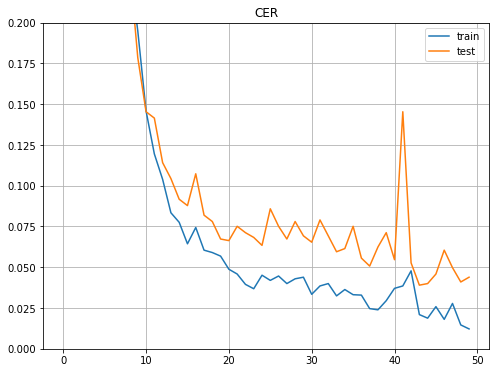

In [10]:
plot_graphs(cer_train_arr, cer_test_arr)

In [11]:
optimizer_dl = torch.optim.Adam(net.parameters(), lr=0.0003)
net = train_model(net, criterion, optimizer_dl, trainloader, 20, cer_train_arr, cer_test_arr)

0it [00:00, ?it/s]

Epoch 1/20, iteration 20, loss: 0.0147

CER on train = 0.010731707327067852


0it [00:00, ?it/s]

CER on test = 0.02926829271018505


0it [00:00, ?it/s]

Epoch 2/20, iteration 20, loss: 0.0147

CER on train = 0.010487805120646954


0it [00:00, ?it/s]

CER on test = 0.036097560077905655


0it [00:00, ?it/s]

Epoch 3/20, iteration 20, loss: 0.0147

CER on train = 0.011463414877653122


0it [00:00, ?it/s]

CER on test = 0.03707316890358925


0it [00:00, ?it/s]

Epoch 4/20, iteration 20, loss: 0.0146

CER on train = 0.01243902463465929


0it [00:00, ?it/s]

CER on test = 0.03804878145456314


0it [00:00, ?it/s]

Epoch 5/20, iteration 20, loss: 0.0146

CER on train = 0.014390244148671627


0it [00:00, ?it/s]

CER on test = 0.03999999910593033


0it [00:00, ?it/s]

Epoch 6/20, iteration 20, loss: 0.0146

CER on train = 0.010731707327067852


0it [00:00, ?it/s]

CER on test = 0.03999999910593033


0it [00:00, ?it/s]

Epoch 7/20, iteration 20, loss: 0.0146

CER on train = 0.013170731253921986


0it [00:00, ?it/s]

CER on test = 0.041951220482587814


0it [00:00, ?it/s]

Epoch 8/20, iteration 20, loss: 0.0146

CER on train = 0.014634146355092525


0it [00:00, ?it/s]

CER on test = 0.04292682930827141


0it [00:00, ?it/s]

Epoch 9/20, iteration 20, loss: 0.0146

CER on train = 0.012195121496915817


0it [00:00, ?it/s]

CER on test = 0.036097560077905655


0it [00:00, ?it/s]

Epoch 10/20, iteration 20, loss: 0.0146

CER on train = 0.014390244148671627


0it [00:00, ?it/s]

CER on test = 0.04097560793161392


0it [00:00, ?it/s]

Epoch 11/20, iteration 20, loss: 0.0146

CER on train = 0.013658536598086357


0it [00:00, ?it/s]

CER on test = 0.03999999910593033


0it [00:00, ?it/s]

Epoch 12/20, iteration 20, loss: 0.0146

CER on train = 0.013414634391665459


0it [00:00, ?it/s]

CER on test = 0.03707316890358925


0it [00:00, ?it/s]

Epoch 13/20, iteration 20, loss: 0.0146

CER on train = 0.012682926841080189


0it [00:00, ?it/s]

CER on test = 0.036097560077905655


0it [00:00, ?it/s]

Epoch 14/20, iteration 20, loss: 0.0146

CER on train = 0.013658536598086357


0it [00:00, ?it/s]

CER on test = 0.03512195125222206


0it [00:00, ?it/s]

Epoch 15/20, iteration 20, loss: 0.0146

CER on train = 0.012926829047501087


0it [00:00, ?it/s]

CER on test = 0.03707316890358925


0it [00:00, ?it/s]

Epoch 16/20, iteration 20, loss: 0.0146

CER on train = 0.012682926841080189


0it [00:00, ?it/s]

CER on test = 0.031219512224197388


0it [00:00, ?it/s]

Epoch 17/20, iteration 20, loss: 0.0146

CER on train = 0.012682926841080189


0it [00:00, ?it/s]

CER on test = 0.03804878145456314


0it [00:00, ?it/s]

Epoch 18/20, iteration 20, loss: 0.0146

CER on train = 0.012926829047501087


0it [00:00, ?it/s]

CER on test = 0.03707316890358925


0it [00:00, ?it/s]

Epoch 19/20, iteration 20, loss: 0.0145

CER on train = 0.011463414877653122


0it [00:00, ?it/s]

CER on test = 0.03999999910593033


0it [00:00, ?it/s]

Epoch 20/20, iteration 20, loss: 0.0145

CER on train = 0.013658536598086357


0it [00:00, ?it/s]

CER on test = 0.03707316890358925
Finished Training


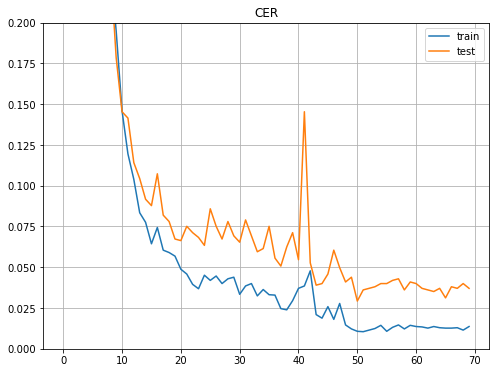

In [12]:
plot_graphs(cer_train_arr, cer_test_arr)

In [13]:
optimizer_dl_dl = torch.optim.Adam(net.parameters(), lr=0.00003)
net = train_model(net, criterion, optimizer_dl_dl, trainloader, 10, cer_train_arr, cer_test_arr)

0it [00:00, ?it/s]

Epoch 1/10, iteration 20, loss: 0.0145

CER on train = 0.013902438804507256


0it [00:00, ?it/s]

CER on test = 0.03804878145456314


0it [00:00, ?it/s]

Epoch 2/10, iteration 20, loss: 0.0145

CER on train = 0.013902438804507256


0it [00:00, ?it/s]

CER on test = 0.03707316890358925


0it [00:00, ?it/s]

Epoch 3/10, iteration 20, loss: 0.0145

CER on train = 0.013414634391665459


0it [00:00, ?it/s]

CER on test = 0.036097560077905655


0it [00:00, ?it/s]

Epoch 4/10, iteration 20, loss: 0.0145

CER on train = 0.013414634391665459


0it [00:00, ?it/s]

CER on test = 0.036097560077905655


0it [00:00, ?it/s]

Epoch 5/10, iteration 20, loss: 0.0145

CER on train = 0.013414634391665459


0it [00:00, ?it/s]

CER on test = 0.03512195125222206


0it [00:00, ?it/s]

Epoch 6/10, iteration 20, loss: 0.0145

CER on train = 0.013414634391665459


0it [00:00, ?it/s]

CER on test = 0.03414634242653847


0it [00:00, ?it/s]

Epoch 7/10, iteration 20, loss: 0.0145

CER on train = 0.013658536598086357


0it [00:00, ?it/s]

CER on test = 0.03414634242653847


0it [00:00, ?it/s]

Epoch 8/10, iteration 20, loss: 0.0145

CER on train = 0.013658536598086357


0it [00:00, ?it/s]

CER on test = 0.033170729875564575


0it [00:00, ?it/s]

Epoch 9/10, iteration 20, loss: 0.0145

CER on train = 0.013658536598086357


0it [00:00, ?it/s]

CER on test = 0.033170729875564575


0it [00:00, ?it/s]

Epoch 10/10, iteration 20, loss: 0.0145

CER on train = 0.013170731253921986


0it [00:00, ?it/s]

CER on test = 0.03414634242653847
Finished Training


### Размер батча
Также я провел эксперименты, варьируя размер батча. Как советует сам Ян Лекун, "training with large minibtaches is bad for your health". Поэтому я менял размер батча не только в большую сторону.
Однако ничего лучше, чем в случае когда batch_size = 41, поучить не удалось. Либо тестовая метрика не опускалась ниже 5%, либо все вычисления "замерзали" и сеть постоянно предсказывала один конкретный символ.

## 3. Подсчет метрик  
  
В качестве метрики предлагалось использовать Character Error Rate (CER), который считается по следующей формуле:
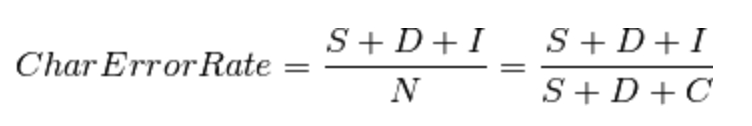
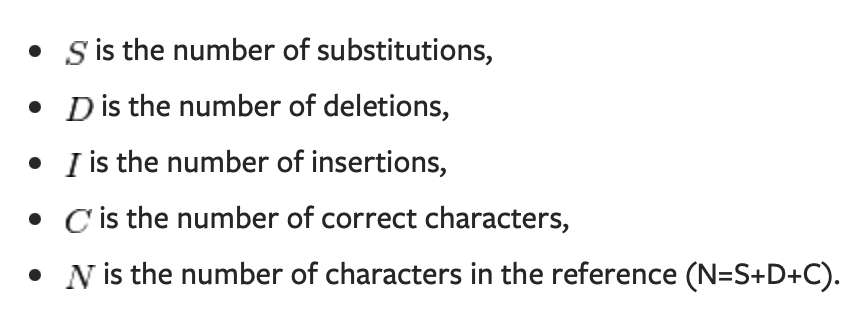

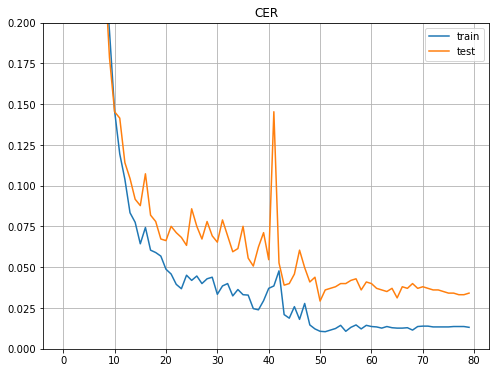

In [14]:
plot_graphs(cer_train_arr, cer_test_arr)

Видим, что уменьшение темпа обучения не привело к улучшению результатов на тесте. Напротив, стало даже немного хуже. Однако такая картина наблюдалась невсегда. Ввиду случайности на некоторорых эксперимантах снижение lr помогало немного улучшить результат.  
В данном же случае разумно остановиться на 50 эпохе.
  
Посмотрим на значение CER в этом случае:

In [15]:
print(f"CER on test = {np.min(cer_test_arr) * 100:.3}%")

CER on test = 2.93%


Данное значение метрики говорит о хорошей точности модели.

## 4. Анализ ошибок модели

In [16]:
net.eval()
labels_array = []
cer_array = []
preds_array = []
with torch.no_grad():
    for i, data in tqdm(enumerate(testloader, 0)):
        inputs, labels = data    

        outputs = net(inputs)

        _, max_ind = torch.max(outputs,dim  = 2)
        words = [[] for _ in range(len(max_ind))]
        for j in range(len(words)):
            tmp = max_ind[j].data.numpy()
            words[j] = "".join([idx_to_token[idx] for idx in tmp])

        for label, word in zip(labels, words):
            cer_array.append(torchmetrics.functional.char_error_rate(preds=word, target=label))
            labels_array.append(label)
            preds_array.append(word)

0it [00:00, ?it/s]

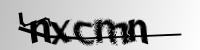

True label of image = nxcmn
Predicted label = mxcnn
CER = 0.40


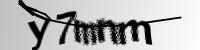

True label of image = y7mnm
Predicted label = y7mmn
CER = 0.40


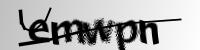

True label of image = emwpn
Predicted label = enwpp
CER = 0.40


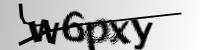

True label of image = w6pxy
Predicted label = w6ppy
CER = 0.20


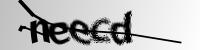

True label of image = neecd
Predicted label = neccd
CER = 0.20


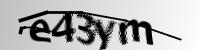

True label of image = e43ym
Predicted label = e43yn
CER = 0.20


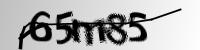

True label of image = 65m85
Predicted label = 65n85
CER = 0.20


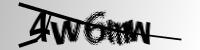

True label of image = 4w6mw
Predicted label = 4w66w
CER = 0.20


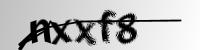

True label of image = nxxf8
Predicted label = bxxf8
CER = 0.20


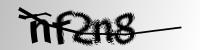

True label of image = nf2n8
Predicted label = mf2n8
CER = 0.20


In [17]:
NUM_WORST_EXAMPLES = 10


def show_worst_pic(all_labels, cer_array, preds_array):
    max_idxs = (-np.array(cer_array)).argsort()[:10]
    for i in range(NUM_WORST_EXAMPLES):
        idx = max_idxs[i]
        image = Image.open('./samples/' + f'{all_labels[idx]}' + '.png').convert('RGB')
        img = to_tensor(image)
        img = torchvision.transforms.ToPILImage()(img).convert("RGB")
        display(img)
        print(f"True label of image = {all_labels[idx]}")
        print(f"Predicted label = {preds_array[idx]}")
        print(f"CER = {cer_array[idx]:.2f}")
        

show_worst_pic(labels_array, cer_array, preds_array)

Наиболее характерная ошибка для полученной нейросети - неправильное предсказание буквы `n` на месте `m` и наоборот. Очевидно, это вызвано схожестью написания этих букв. Тоже самое можно сказать про символы `6` и `b` или `e` и `c`. По некоторым капчам даже человку невсегда просто сказать, какая именно буква написана.  
Кроме того, вероятно, что дополнительные помехи при распознавании вводятся полосками. Они как раз таки и запутывают сеть еще больше.  
Ошибки также часто возникают, когда буквы `m` и `n` написаны вместе. В этом случае сети тяжело понять, в каком именно порядке расположены символы.

Что касается путей решения - то один из вариантов - повышение контрастности картинки. То есть мы хотим сделать темные цвета более темными, а светлые (сюрприз) - более светлыми, и тем самым акцентировать внимание на разделениях между буквами.  
Еще один вариант - научиться каким-то образом выделять полоски и двигать их вверх и вниз, добавляя наблюдения в нашу трейновую выборку (как вариант data augmentation).
Также можно поиграться с размытием, так как на некоторых картинках видно, что цифры намеренно изображены нечетко. В этом может помочь GaussianBlur из pytorch.

### Data augmentation в целом кажется довольно перспективным направлением, попробуем поэкспериментировать:

### Вполне разумно предположить, что символы в капче могут быть поеврнуты на разные углы.  Поэтому попробуем повернуть часть картинок на случайный угол

In [46]:
test_class = CustomDataClass('./samples1/', to_tensor)
train, test = torch.utils.data.random_split(test_class, [0.8, 0.2])

In [47]:
NUMBER_ROT_IMG = 416
DEGREE = 9


def add_rotation_imgs(X_train_shft, y_train_shft):
    for i in range(NUMBER_ROT_IMG):
        idx = np.random.randint(0, len(train))
        rand_idxs.append(idx)
        label = train[idx][1]
        orig_img = Image.open('./samples1/' + f'{label}' + '.png').convert('RGB')
        rotated_img = torchvision.transforms.RandomRotation(degrees=DEGREE)(orig_img)
        rotated_img = torchvision.transforms.ToTensor()(rotated_img)
        X_train_rot.append(rotated_img)
        y_train_rot.append(label)
    return X_train_rot, y_train_rot
        
    

rand_idxs = []
X_train_rot = []
y_train_rot = []
X_train_rot, y_train_rot = add_rotation_imgs(X_train_rot, y_train_rot)

### Проверим, как нам удалось повернуть картинки. Сверху выведем повернутой изображение, а снизу оригинал

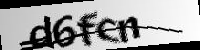

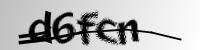

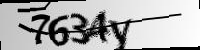

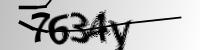

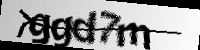

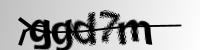

In [48]:
NUM_IMG_TO_SHOW = 3

    
def show_image(shifted_imgs, NUM_IMG_TO_SHOW, figsize=(16, 9)):
    for i in range(NUM_IMG_TO_SHOW):
        img_sh = shifted_imgs[i]
        im = torchvision.transforms.ToPILImage()(img_sh).convert("RGB")
        display(im)
        img_orig = train[rand_idxs[i]][0]
        im = torchvision.transforms.ToPILImage()(img_orig).convert("RGB")
        display(im)
        print()

        
show_image(X_train_rot, NUM_IMG_TO_SHOW)

In [49]:
def concat_train_sets(train_all, train_0, x_train_1, y_train_1):
    train_all = []
    for i in range(len(train_0)):
        train_all.append((train_0[i][0], train_0[i][1]))
    for i in range(len(x_train_1)):
        train_all.append((x_train_1[i], y_train_1[i]))
    return train_all


train_all = []
train_all = concat_train_sets(train_all, train, X_train_rot, y_train_rot)

### Проверим, что размер трейновой выборки действительно увеличился (то есть мы добавили повернутые картинки)

In [50]:
len(train_all)

1248

In [51]:
batch_size = 104

trainloader = torch.utils.data.DataLoader(train_all, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                          shuffle=True)

In [52]:
import torch.nn as nn
import torch.nn.functional as F


hidden_size = len(vocab)
num_layers = 1
capcha_size = 5
num_epochs = 75


class Net(nn.Module):
    def __init__(self,              
                 num_layers_cnn = 4,
                 padding = ['same', 'same', 'same', (0, 0)],
                 kernel_size=[(5, 5), (5, 5), (5, 5), (2, 2)],
                 num_convs = [(3, 30), (30, 60), (60, 90), (90, 180)],
                 pool_size=[(2, 4), (1, 2), (1, 2), (1, 2)]
                ):
        
        super(Net, self).__init__()
        
        self.num_layers_cnn = num_layers_cnn
        self.model = torch.nn.Sequential()
        for i in range(self.num_layers_cnn):
            self.model.add_module(f"conv+{i}", nn.Conv2d(num_convs[i][0], num_convs[i][1], kernel_size[i], padding = padding[i]))
            self.model.add_module(f"relu+{i}", nn.LeakyReLU())
            self.model.add_module(f"pool+{i}", nn.MaxPool2d(pool_size[i]))
      
        height = [50 for _ in range(num_layers_cnn + 1)]
        vert_comp = 1.0    
        for i in range(1, num_layers_cnn + 1):
            if padding[i - 1] == 'same':
                height[i] = height[i - 1]
            else:
                height[i] = height[i - 1] + 2 * padding[i - 1][0] - (kernel_size[i - 1][0] - 1)
            height[i] = int(height[i] / pool_size[i - 1][0])
            
        self.lstm = nn.LSTM(int(num_convs[-1][1] * height[-1]), hidden_size, num_layers, batch_first=True,
            bidirectional=True)


    def forward(self, x):
        x = self.model(x)
        x = torch.reshape(x, (x.shape[0], x.shape[1] * x.shape[2], x.shape[3]))
        x = x.mT
        h0 = torch.zeros(num_layers * 2, batch_size, hidden_size, requires_grad=True)
        c0 = torch.zeros(num_layers * 2, batch_size, hidden_size, requires_grad=True)
        x, (h_n, c_n) = self.lstm(x, (h0, c0))
        x = x.reshape(x.shape[0], x.shape[1], 2, int(x.shape[2] / 2))
        x = x.sum(dim = -2)
        return x


net = Net()

In [53]:
cer_train_arr_rt_img = []
cer_test_arr_rt_img = []
optimizer = torch.optim.Adam(net.parameters(), lr=0.003)
net = train_model(net, criterion, optimizer, trainloader, num_epochs, cer_train_arr_rt_img, cer_test_arr_rt_img)

0it [00:00, ?it/s]

Epoch 1/75, iteration 8, loss: 0.0126

CER on train = 0.9237179756164551


0it [00:00, ?it/s]

CER on test = 0.9644230604171753


0it [00:00, ?it/s]

Epoch 2/75, iteration 8, loss: 0.0119

CER on train = 0.9043269157409668


0it [00:00, ?it/s]

CER on test = 0.8759615421295166


0it [00:00, ?it/s]

Epoch 3/75, iteration 8, loss: 0.0116

CER on train = 0.8762820363044739


0it [00:00, ?it/s]

CER on test = 0.8673076629638672


0it [00:00, ?it/s]

Epoch 4/75, iteration 8, loss: 0.0111

CER on train = 0.8358974456787109


0it [00:00, ?it/s]

CER on test = 0.7778846025466919


0it [00:00, ?it/s]

Epoch 5/75, iteration 8, loss: 0.0106

CER on train = 0.7653846144676208


0it [00:00, ?it/s]

CER on test = 0.7028846144676208


0it [00:00, ?it/s]

Epoch 6/75, iteration 8, loss: 0.0104

CER on train = 0.740705132484436


0it [00:00, ?it/s]

CER on test = 0.6807692050933838


0it [00:00, ?it/s]

Epoch 7/75, iteration 8, loss: 0.0100

CER on train = 0.6927884817123413


0it [00:00, ?it/s]

CER on test = 0.7355769276618958


0it [00:00, ?it/s]

Epoch 8/75, iteration 8, loss: 0.0098

CER on train = 0.6613782048225403


0it [00:00, ?it/s]

CER on test = 0.6307692527770996


0it [00:00, ?it/s]

Epoch 9/75, iteration 8, loss: 0.0095

CER on train = 0.607852578163147


0it [00:00, ?it/s]

CER on test = 0.5865384340286255


0it [00:00, ?it/s]

Epoch 10/75, iteration 8, loss: 0.0090

CER on train = 0.5134615302085876


0it [00:00, ?it/s]

CER on test = 0.4375


0it [00:00, ?it/s]

Epoch 11/75, iteration 8, loss: 0.0081

CER on train = 0.41314101219177246


0it [00:00, ?it/s]

CER on test = 0.3076923191547394


0it [00:00, ?it/s]

Epoch 12/75, iteration 8, loss: 0.0074

CER on train = 0.29759615659713745


0it [00:00, ?it/s]

CER on test = 0.21057692170143127


0it [00:00, ?it/s]

Epoch 13/75, iteration 8, loss: 0.0070

CER on train = 0.22708334028720856


0it [00:00, ?it/s]

CER on test = 0.16923077404499054


0it [00:00, ?it/s]

Epoch 14/75, iteration 8, loss: 0.0069

CER on train = 0.2088140994310379


0it [00:00, ?it/s]

CER on test = 0.1836538463830948


0it [00:00, ?it/s]

Epoch 15/75, iteration 8, loss: 0.0068

CER on train = 0.20048077404499054


0it [00:00, ?it/s]

CER on test = 0.19230769574642181


0it [00:00, ?it/s]

Epoch 16/75, iteration 8, loss: 0.0067

CER on train = 0.1761218011379242


0it [00:00, ?it/s]

CER on test = 0.12115384638309479


0it [00:00, ?it/s]

Epoch 17/75, iteration 8, loss: 0.0066

CER on train = 0.13717949390411377


0it [00:00, ?it/s]

CER on test = 0.11538461595773697


0it [00:00, ?it/s]

Epoch 18/75, iteration 8, loss: 0.0065

CER on train = 0.11618589609861374


0it [00:00, ?it/s]

CER on test = 0.1259615421295166


0it [00:00, ?it/s]

Epoch 19/75, iteration 8, loss: 0.0065

CER on train = 0.11073718219995499


0it [00:00, ?it/s]

CER on test = 0.09903845936059952


0it [00:00, ?it/s]

Epoch 20/75, iteration 8, loss: 0.0064

CER on train = 0.09455128014087677


0it [00:00, ?it/s]

CER on test = 0.08749999850988388


0it [00:00, ?it/s]

Epoch 21/75, iteration 8, loss: 0.0063

CER on train = 0.07964743673801422


0it [00:00, ?it/s]

CER on test = 0.07307692617177963


0it [00:00, ?it/s]

Epoch 22/75, iteration 8, loss: 0.0063

CER on train = 0.0738782063126564


0it [00:00, ?it/s]

CER on test = 0.0615384615957737


0it [00:00, ?it/s]

Epoch 23/75, iteration 8, loss: 0.0062

CER on train = 0.0634615421295166


0it [00:00, ?it/s]

CER on test = 0.054807692766189575


0it [00:00, ?it/s]

Epoch 24/75, iteration 8, loss: 0.0062

CER on train = 0.05576923117041588


0it [00:00, ?it/s]

CER on test = 0.05673076957464218


0it [00:00, ?it/s]

Epoch 25/75, iteration 8, loss: 0.0062

CER on train = 0.05368589609861374


0it [00:00, ?it/s]

CER on test = 0.05673076957464218


0it [00:00, ?it/s]

Epoch 26/75, iteration 8, loss: 0.0061

CER on train = 0.048878204077482224


0it [00:00, ?it/s]

CER on test = 0.05288461595773697


0it [00:00, ?it/s]

Epoch 27/75, iteration 8, loss: 0.0061

CER on train = 0.04294871911406517


0it [00:00, ?it/s]

CER on test = 0.05096153914928436


0it [00:00, ?it/s]

Epoch 28/75, iteration 8, loss: 0.0061

CER on train = 0.03910256549715996


0it [00:00, ?it/s]

CER on test = 0.05288461595773697


0it [00:00, ?it/s]

Epoch 29/75, iteration 8, loss: 0.0061

CER on train = 0.038942307233810425


0it [00:00, ?it/s]

CER on test = 0.05000000074505806


0it [00:00, ?it/s]

Epoch 30/75, iteration 8, loss: 0.0061

CER on train = 0.037660256028175354


0it [00:00, ?it/s]

CER on test = 0.042307693511247635


0it [00:00, ?it/s]

Epoch 31/75, iteration 8, loss: 0.0060

CER on train = 0.03669871762394905


0it [00:00, ?it/s]

CER on test = 0.036538463085889816


0it [00:00, ?it/s]

Epoch 32/75, iteration 8, loss: 0.0060

CER on train = 0.02916666679084301


0it [00:00, ?it/s]

CER on test = 0.04423077031970024


0it [00:00, ?it/s]

Epoch 33/75, iteration 8, loss: 0.0061

CER on train = 0.03141025826334953


0it [00:00, ?it/s]

CER on test = 0.03750000149011612


0it [00:00, ?it/s]

Epoch 34/75, iteration 8, loss: 0.0060

CER on train = 0.03157051280140877


0it [00:00, ?it/s]

CER on test = 0.04615384712815285


0it [00:00, ?it/s]

Epoch 35/75, iteration 8, loss: 0.0060

CER on train = 0.025160256773233414


0it [00:00, ?it/s]

CER on test = 0.036538463085889816


0it [00:00, ?it/s]

Epoch 36/75, iteration 8, loss: 0.0060

CER on train = 0.025320513173937798


0it [00:00, ?it/s]

CER on test = 0.036538463085889816


0it [00:00, ?it/s]

Epoch 37/75, iteration 8, loss: 0.0060

CER on train = 0.02756410278379917


0it [00:00, ?it/s]

CER on test = 0.039423078298568726


0it [00:00, ?it/s]

Epoch 38/75, iteration 8, loss: 0.0060

CER on train = 0.025320513173937798


0it [00:00, ?it/s]

CER on test = 0.039423078298568726


0it [00:00, ?it/s]

Epoch 39/75, iteration 8, loss: 0.0060

CER on train = 0.021474359557032585


0it [00:00, ?it/s]

CER on test = 0.03846153989434242


0it [00:00, ?it/s]

Epoch 40/75, iteration 8, loss: 0.0060

CER on train = 0.019391026347875595


0it [00:00, ?it/s]

CER on test = 0.042307693511247635


0it [00:00, ?it/s]

Epoch 41/75, iteration 8, loss: 0.0060

CER on train = 0.015705129131674767


0it [00:00, ?it/s]

CER on test = 0.036538463085889816


0it [00:00, ?it/s]

Epoch 42/75, iteration 8, loss: 0.0060

CER on train = 0.016987180337309837


0it [00:00, ?it/s]

CER on test = 0.03461538627743721


0it [00:00, ?it/s]

Epoch 43/75, iteration 8, loss: 0.0060

CER on train = 0.015384615398943424


0it [00:00, ?it/s]

CER on test = 0.03076923079788685


0it [00:00, ?it/s]

Epoch 44/75, iteration 8, loss: 0.0060

CER on train = 0.014583333395421505


0it [00:00, ?it/s]

CER on test = 0.032692309468984604


0it [00:00, ?it/s]

Epoch 45/75, iteration 8, loss: 0.0060

CER on train = 0.012660256586968899


0it [00:00, ?it/s]

CER on test = 0.0317307710647583


0it [00:00, ?it/s]

Epoch 46/75, iteration 8, loss: 0.0059

CER on train = 0.01394230779260397


0it [00:00, ?it/s]

CER on test = 0.02211538515985012


0it [00:00, ?it/s]

Epoch 47/75, iteration 8, loss: 0.0059

CER on train = 0.012660256586968899


0it [00:00, ?it/s]

CER on test = 0.024038461968302727


0it [00:00, ?it/s]

Epoch 48/75, iteration 8, loss: 0.0059

CER on train = 0.011538461782038212


0it [00:00, ?it/s]

CER on test = 0.03750000149011612


0it [00:00, ?it/s]

Epoch 49/75, iteration 8, loss: 0.0060

CER on train = 0.012339743785560131


0it [00:00, ?it/s]

CER on test = 0.03076923079788685


0it [00:00, ?it/s]

Epoch 50/75, iteration 8, loss: 0.0059

CER on train = 0.012179487384855747


0it [00:00, ?it/s]

CER on test = 0.032692309468984604


0it [00:00, ?it/s]

Epoch 51/75, iteration 8, loss: 0.0059

CER on train = 0.009294872172176838


0it [00:00, ?it/s]

CER on test = 0.0317307710647583


0it [00:00, ?it/s]

Epoch 52/75, iteration 8, loss: 0.0059

CER on train = 0.007371794898062944


0it [00:00, ?it/s]

CER on test = 0.021153846755623817


0it [00:00, ?it/s]

Epoch 53/75, iteration 8, loss: 0.0059

CER on train = 0.0072115384973585606


0it [00:00, ?it/s]

CER on test = 0.020192308351397514


0it [00:00, ?it/s]

Epoch 54/75, iteration 8, loss: 0.0059

CER on train = 0.006410256493836641


0it [00:00, ?it/s]

CER on test = 0.016346154734492302


0it [00:00, ?it/s]

Epoch 55/75, iteration 8, loss: 0.0059

CER on train = 0.004166666883975267


0it [00:00, ?it/s]

CER on test = 0.023076923564076424


0it [00:00, ?it/s]

Epoch 56/75, iteration 8, loss: 0.0059

CER on train = 0.0051282052882015705


0it [00:00, ?it/s]

CER on test = 0.017307693138718605


0it [00:00, ?it/s]

Epoch 57/75, iteration 8, loss: 0.0059

CER on train = 0.0051282052882015705


0it [00:00, ?it/s]

CER on test = 0.015384615398943424


0it [00:00, ?it/s]

Epoch 58/75, iteration 8, loss: 0.0059

CER on train = 0.004807692486792803


0it [00:00, ?it/s]

CER on test = 0.018269231542944908


0it [00:00, ?it/s]

Epoch 59/75, iteration 8, loss: 0.0059

CER on train = 0.004647436086088419


0it [00:00, ?it/s]

CER on test = 0.01923076994717121


0it [00:00, ?it/s]

Epoch 60/75, iteration 8, loss: 0.0059

CER on train = 0.005288461688905954


0it [00:00, ?it/s]

CER on test = 0.026923077180981636


0it [00:00, ?it/s]

Epoch 61/75, iteration 8, loss: 0.0059

CER on train = 0.004166666883975267


0it [00:00, ?it/s]

CER on test = 0.02211538515985012


0it [00:00, ?it/s]

Epoch 62/75, iteration 8, loss: 0.0059

CER on train = 0.003685897449031472


0it [00:00, ?it/s]

CER on test = 0.020192308351397514


0it [00:00, ?it/s]

Epoch 63/75, iteration 8, loss: 0.0059

CER on train = 0.002724359044805169


0it [00:00, ?it/s]

CER on test = 0.018269231542944908


0it [00:00, ?it/s]

Epoch 64/75, iteration 8, loss: 0.0059

CER on train = 0.0032051282469183207


0it [00:00, ?it/s]

CER on test = 0.015384615398943424


0it [00:00, ?it/s]

Epoch 65/75, iteration 8, loss: 0.0059

CER on train = 0.002724359044805169


0it [00:00, ?it/s]

CER on test = 0.020192308351397514


0it [00:00, ?it/s]

Epoch 66/75, iteration 8, loss: 0.0059

CER on train = 0.0035256410483270884


0it [00:00, ?it/s]

CER on test = 0.01923076994717121


0it [00:00, ?it/s]

Epoch 67/75, iteration 8, loss: 0.0059

CER on train = 0.003044871846213937


0it [00:00, ?it/s]

CER on test = 0.01923076994717121


0it [00:00, ?it/s]

Epoch 68/75, iteration 8, loss: 0.0059

CER on train = 0.0033653846476227045


0it [00:00, ?it/s]

CER on test = 0.020192308351397514


0it [00:00, ?it/s]

Epoch 69/75, iteration 8, loss: 0.0059

CER on train = 0.0033653846476227045


0it [00:00, ?it/s]

CER on test = 0.01923076994717121


0it [00:00, ?it/s]

Epoch 70/75, iteration 8, loss: 0.0059

CER on train = 0.0035256410483270884


0it [00:00, ?it/s]

CER on test = 0.026923077180981636


0it [00:00, ?it/s]

Epoch 71/75, iteration 8, loss: 0.0059

CER on train = 0.0033653846476227045


0it [00:00, ?it/s]

CER on test = 0.024038461968302727


0it [00:00, ?it/s]

Epoch 72/75, iteration 8, loss: 0.0059

CER on train = 0.002884615445509553


0it [00:00, ?it/s]

CER on test = 0.021153846755623817


0it [00:00, ?it/s]

Epoch 73/75, iteration 8, loss: 0.0059

CER on train = 0.0033653846476227045


0it [00:00, ?it/s]

CER on test = 0.017307693138718605


0it [00:00, ?it/s]

Epoch 74/75, iteration 8, loss: 0.0059

CER on train = 0.002884615445509553


0it [00:00, ?it/s]

CER on test = 0.025961538776755333


0it [00:00, ?it/s]

Epoch 75/75, iteration 8, loss: 0.0059

CER on train = 0.003044871846213937


0it [00:00, ?it/s]

CER on test = 0.029807692393660545
Finished Training


In [56]:
optimizer_dl = torch.optim.Adam(net.parameters(), lr=0.0003)
net = train_model(net, criterion, optimizer_dl, trainloader, 30, cer_train_arr_rt_img, cer_test_arr_rt_img)

0it [00:00, ?it/s]

Epoch 1/30, iteration 8, loss: 0.0059

CER on train = 0.002884615445509553


0it [00:00, ?it/s]

CER on test = 0.016346154734492302


0it [00:00, ?it/s]

Epoch 2/30, iteration 8, loss: 0.0059

CER on train = 0.002884615445509553


0it [00:00, ?it/s]

CER on test = 0.018269231542944908


0it [00:00, ?it/s]

Epoch 3/30, iteration 8, loss: 0.0059

CER on train = 0.0025641026441007853


0it [00:00, ?it/s]

CER on test = 0.017307693138718605


0it [00:00, ?it/s]

Epoch 4/30, iteration 8, loss: 0.0059

CER on train = 0.0024038462433964014


0it [00:00, ?it/s]

CER on test = 0.014423076994717121


0it [00:00, ?it/s]

Epoch 5/30, iteration 8, loss: 0.0059

CER on train = 0.0024038462433964014


0it [00:00, ?it/s]

CER on test = 0.014423076994717121


0it [00:00, ?it/s]

Epoch 6/30, iteration 8, loss: 0.0059

CER on train = 0.0025641026441007853


0it [00:00, ?it/s]

CER on test = 0.015384615398943424


0it [00:00, ?it/s]

Epoch 7/30, iteration 8, loss: 0.0058

CER on train = 0.0025641026441007853


0it [00:00, ?it/s]

CER on test = 0.017307693138718605


0it [00:00, ?it/s]

Epoch 8/30, iteration 8, loss: 0.0059

CER on train = 0.0025641026441007853


0it [00:00, ?it/s]

CER on test = 0.016346154734492302


0it [00:00, ?it/s]

Epoch 9/30, iteration 8, loss: 0.0059

CER on train = 0.0024038462433964014


0it [00:00, ?it/s]

CER on test = 0.016346154734492302


0it [00:00, ?it/s]

Epoch 10/30, iteration 8, loss: 0.0059

CER on train = 0.0024038462433964014


0it [00:00, ?it/s]

CER on test = 0.016346154734492302


0it [00:00, ?it/s]

Epoch 11/30, iteration 8, loss: 0.0059

CER on train = 0.0022435898426920176


0it [00:00, ?it/s]

CER on test = 0.015384615398943424


0it [00:00, ?it/s]

Epoch 12/30, iteration 8, loss: 0.0059

CER on train = 0.0024038462433964014


0it [00:00, ?it/s]

CER on test = 0.013461538590490818


0it [00:00, ?it/s]

Epoch 13/30, iteration 8, loss: 0.0059

CER on train = 0.0024038462433964014


0it [00:00, ?it/s]

CER on test = 0.017307693138718605


0it [00:00, ?it/s]

Epoch 14/30, iteration 8, loss: 0.0059

CER on train = 0.002724359044805169


0it [00:00, ?it/s]

CER on test = 0.012500000186264515


0it [00:00, ?it/s]

Epoch 15/30, iteration 8, loss: 0.0059

CER on train = 0.0024038462433964014


0it [00:00, ?it/s]

CER on test = 0.014423076994717121


0it [00:00, ?it/s]

Epoch 16/30, iteration 8, loss: 0.0059

CER on train = 0.0025641026441007853


0it [00:00, ?it/s]

CER on test = 0.015384615398943424


0it [00:00, ?it/s]

Epoch 17/30, iteration 8, loss: 0.0059

CER on train = 0.0024038462433964014


0it [00:00, ?it/s]

CER on test = 0.017307693138718605


0it [00:00, ?it/s]

Epoch 18/30, iteration 8, loss: 0.0059

CER on train = 0.0025641026441007853


0it [00:00, ?it/s]

CER on test = 0.017307693138718605


0it [00:00, ?it/s]

Epoch 19/30, iteration 8, loss: 0.0058

CER on train = 0.0025641026441007853


0it [00:00, ?it/s]

CER on test = 0.01923076994717121


0it [00:00, ?it/s]

Epoch 20/30, iteration 8, loss: 0.0058

CER on train = 0.0024038462433964014


0it [00:00, ?it/s]

CER on test = 0.021153846755623817


0it [00:00, ?it/s]

Epoch 21/30, iteration 8, loss: 0.0058

CER on train = 0.0025641026441007853


0it [00:00, ?it/s]

CER on test = 0.01923076994717121


0it [00:00, ?it/s]

Epoch 22/30, iteration 8, loss: 0.0058

CER on train = 0.0025641026441007853


0it [00:00, ?it/s]

CER on test = 0.020192308351397514


0it [00:00, ?it/s]

Epoch 23/30, iteration 8, loss: 0.0058

CER on train = 0.0025641026441007853


0it [00:00, ?it/s]

CER on test = 0.025961538776755333


0it [00:00, ?it/s]

Epoch 24/30, iteration 8, loss: 0.0058

CER on train = 0.0022435898426920176


0it [00:00, ?it/s]

CER on test = 0.021153846755623817


0it [00:00, ?it/s]

Epoch 25/30, iteration 8, loss: 0.0058

CER on train = 0.0024038462433964014


0it [00:00, ?it/s]

CER on test = 0.017307693138718605


0it [00:00, ?it/s]

Epoch 26/30, iteration 8, loss: 0.0058

CER on train = 0.002724359044805169


0it [00:00, ?it/s]

CER on test = 0.017307693138718605


0it [00:00, ?it/s]

Epoch 27/30, iteration 8, loss: 0.0058

CER on train = 0.0025641026441007853


0it [00:00, ?it/s]

CER on test = 0.02211538515985012


0it [00:00, ?it/s]

Epoch 28/30, iteration 8, loss: 0.0058

CER on train = 0.0022435898426920176


0it [00:00, ?it/s]

CER on test = 0.01923076994717121


0it [00:00, ?it/s]

Epoch 29/30, iteration 8, loss: 0.0058

CER on train = 0.0024038462433964014


0it [00:00, ?it/s]

CER on test = 0.01923076994717121


0it [00:00, ?it/s]

Epoch 30/30, iteration 8, loss: 0.0058

CER on train = 0.0025641026441007853


0it [00:00, ?it/s]

CER on test = 0.01923076994717121
Finished Training


In [57]:
optimizer_dl_dl = torch.optim.Adam(net.parameters(), lr=0.0003)
net = train_model(net, criterion, optimizer_dl_dl, trainloader, 10, cer_train_arr_rt_img, cer_test_arr_rt_img)

0it [00:00, ?it/s]

Epoch 1/10, iteration 8, loss: 0.0058

CER on train = 0.0025641026441007853


0it [00:00, ?it/s]

CER on test = 0.01923076994717121


0it [00:00, ?it/s]

Epoch 2/10, iteration 8, loss: 0.0058

CER on train = 0.0024038462433964014


0it [00:00, ?it/s]

CER on test = 0.016346154734492302


0it [00:00, ?it/s]

Epoch 3/10, iteration 8, loss: 0.0058

CER on train = 0.002724359044805169


0it [00:00, ?it/s]

CER on test = 0.02211538515985012


0it [00:00, ?it/s]

Epoch 4/10, iteration 8, loss: 0.0058

CER on train = 0.002724359044805169


0it [00:00, ?it/s]

CER on test = 0.02500000037252903


0it [00:00, ?it/s]

Epoch 5/10, iteration 8, loss: 0.0058

CER on train = 0.002724359044805169


0it [00:00, ?it/s]

CER on test = 0.01923076994717121


0it [00:00, ?it/s]

Epoch 6/10, iteration 8, loss: 0.0058

CER on train = 0.002724359044805169


0it [00:00, ?it/s]

CER on test = 0.018269231542944908


0it [00:00, ?it/s]

Epoch 7/10, iteration 8, loss: 0.0058

CER on train = 0.002724359044805169


0it [00:00, ?it/s]

CER on test = 0.017307693138718605


0it [00:00, ?it/s]

Epoch 8/10, iteration 8, loss: 0.0058

CER on train = 0.002724359044805169


0it [00:00, ?it/s]

CER on test = 0.020192308351397514


0it [00:00, ?it/s]

Epoch 9/10, iteration 8, loss: 0.0058

CER on train = 0.002724359044805169


0it [00:00, ?it/s]

CER on test = 0.016346154734492302


0it [00:00, ?it/s]

Epoch 10/10, iteration 8, loss: 0.0058

CER on train = 0.002724359044805169


0it [00:00, ?it/s]

CER on test = 0.017307693138718605
Finished Training


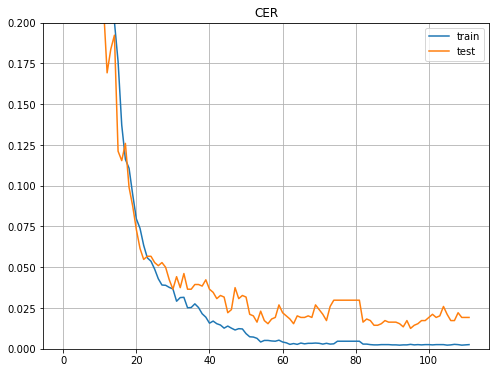

In [58]:
plot_graphs(cer_train_arr_rt_img, cer_test_arr_rt_img)

In [59]:
print(f"CER on test (with data augmentatin) = {np.min(cer_test_arr_rt_img) * 100:.3}%")

CER on test (with data augmentatin) = 1.25%


Видно, что достаточно было остановиться примерно на 65 эпохах. Дальнейшее обучение почти не улучшает результат.
Тем не менее нам удалось повысить качество модели более чем не 1.5%

### Теперь, в дополнение к уже сделанному, попроубем сдвигать пиксели у изображений на случайное число вправо, влево, вниз или вверх

In [61]:
NUMBER_SHIFTED_IMG = 416
MAX_X_SHIFT = 20
MAX_Y_SHIFT = 7


def shift_img(image, dx, dy):
    shifted_img = shift(image, [0, dy, dx], mode="nearest")
    tmp = to_tensor(shifted_img)
    tmp = torch.permute(tmp, (1, 2, 0))
    return tmp


def add_shifted_imgs(X_train_shft, y_train_shft):
    for _ in range(NUMBER_SHIFTED_IMG):
        i = np.random.randint(0, len(train))
        rand_idxs.append(i)
        x_or_y = np.random.randint(0, 2)
        if x_or_y == 0:
            dx = 0
            dy = np.random.choice([- MAX_Y_SHIFT, - MAX_Y_SHIFT + 2, MAX_Y_SHIFT - 2, MAX_Y_SHIFT])
        else:
            dx = np.random.choice([- MAX_X_SHIFT, - MAX_X_SHIFT + 5, MAX_X_SHIFT - 5, MAX_X_SHIFT])
            dy = 0
        elem = train[i]
        X_train_shft.append(shift_img(elem[0], dx, dy))
        y_train_shft.append(elem[1])
    return X_train_shft, y_train_shft
    
    
rand_idxs = []
X_train_shft = []
y_train_shft = []
X_train_shft, y_train_shft = add_shifted_imgs(X_train_shft, y_train_shft)

### Проверим, как нам удалось подвигать картинки. Сверху выведем сдвинутое изображение, а снизу оригинал

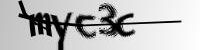

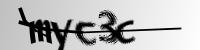

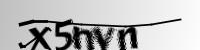

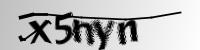

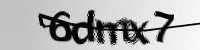

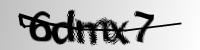

In [62]:
show_image(X_train_shft, NUM_IMG_TO_SHOW)

In [64]:
train_all_2 = []
train_all_2 = concat_train_sets(train_all_2, train_all, X_train_shft, y_train_shft)

### Проверим, что размер трейновой выборки действительно увеличился (то есть мы добавили сдвинутые картинки)

In [66]:
len(train_all_2)

1664

In [67]:
batch_size = 104

trainloader = torch.utils.data.DataLoader(train_all_2, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                          shuffle=True)

In [68]:
import torch.nn as nn
import torch.nn.functional as F


hidden_size = len(vocab)
num_layers = 1
capcha_size = 5
num_epochs = 60


class Net(nn.Module):
    def __init__(self,              
                 num_layers_cnn = 4,
                 padding = ['same', 'same', 'same', (0, 0)],
                 kernel_size=[(5, 5), (5, 5), (5, 5), (2, 2)],
                 num_convs = [(3, 30), (30, 60), (60, 90), (90, 180)],
                 pool_size=[(2, 4), (1, 2), (1, 2), (1, 2)]
                ):
        
        super(Net, self).__init__()
        
        self.num_layers_cnn = num_layers_cnn
        self.model = torch.nn.Sequential()
        for i in range(self.num_layers_cnn):
            self.model.add_module(f"conv+{i}", nn.Conv2d(num_convs[i][0], num_convs[i][1], kernel_size[i], padding = padding[i]))
            self.model.add_module(f"relu+{i}", nn.LeakyReLU())
            self.model.add_module(f"pool+{i}", nn.MaxPool2d(pool_size[i]))
      
        height = [50 for _ in range(num_layers_cnn + 1)]
        vert_comp = 1.0    
        for i in range(1, num_layers_cnn + 1):
            if padding[i - 1] == 'same':
                height[i] = height[i - 1]
            else:
                height[i] = height[i - 1] + 2 * padding[i - 1][0] - (kernel_size[i - 1][0] - 1)
            height[i] = int(height[i] / pool_size[i - 1][0])
            
        self.lstm = nn.LSTM(int(num_convs[-1][1] * height[-1]), hidden_size, num_layers, batch_first=True,
            bidirectional=True)


    def forward(self, x):
        x = self.model(x)
        x = torch.reshape(x, (x.shape[0], x.shape[1] * x.shape[2], x.shape[3]))
        x = x.mT
        h0 = torch.zeros(num_layers * 2, batch_size, hidden_size, requires_grad=True)
        c0 = torch.zeros(num_layers * 2, batch_size, hidden_size, requires_grad=True)
        x, (h_n, c_n) = self.lstm(x, (h0, c0))
        x = x.reshape(x.shape[0], x.shape[1], 2, int(x.shape[2] / 2))
        x = x.sum(dim = -2)
        
        return x


net = Net()

In [69]:
cer_train_arr_rt_shft_img = []
cer_test_arr_rt_shft_img = []
optimizer = torch.optim.Adam(net.parameters(), lr=0.003)
net = train_model(net, criterion, optimizer, trainloader, num_epochs, cer_train_arr_rt_shft_img, cer_test_arr_rt_shft_img)

0it [00:00, ?it/s]

Epoch 1/60, iteration 8, loss: 0.0125
Epoch 1/60, iteration 16, loss: 0.0119

CER on train = 0.9120192527770996


0it [00:00, ?it/s]

CER on test = 0.8903846144676208


0it [00:00, ?it/s]

Epoch 2/60, iteration 8, loss: 0.0119
Epoch 2/60, iteration 16, loss: 0.0119

CER on train = 0.9022836685180664


0it [00:00, ?it/s]

CER on test = 0.892307698726654


0it [00:00, ?it/s]

Epoch 3/60, iteration 8, loss: 0.0118
Epoch 3/60, iteration 16, loss: 0.0119

CER on train = 0.901562511920929


0it [00:00, ?it/s]

CER on test = 0.887499988079071


0it [00:00, ?it/s]

Epoch 4/60, iteration 8, loss: 0.0118
Epoch 4/60, iteration 16, loss: 0.0118

CER on train = 0.8972355723381042


0it [00:00, ?it/s]

CER on test = 0.879807710647583


0it [00:00, ?it/s]

Epoch 5/60, iteration 8, loss: 0.0118
Epoch 5/60, iteration 16, loss: 0.0118

CER on train = 0.8961538672447205


0it [00:00, ?it/s]

CER on test = 0.8778846263885498


0it [00:00, ?it/s]

Epoch 6/60, iteration 8, loss: 0.0117
Epoch 6/60, iteration 16, loss: 0.0117

CER on train = 0.885817289352417


0it [00:00, ?it/s]

CER on test = 0.8259615302085876


0it [00:00, ?it/s]

Epoch 7/60, iteration 8, loss: 0.0114
Epoch 7/60, iteration 16, loss: 0.0114

CER on train = 0.8676682710647583


0it [00:00, ?it/s]

CER on test = 0.8105769157409668


0it [00:00, ?it/s]

Epoch 8/60, iteration 8, loss: 0.0112
Epoch 8/60, iteration 16, loss: 0.0111

CER on train = 0.8443509340286255


0it [00:00, ?it/s]

CER on test = 0.7634615302085876


0it [00:00, ?it/s]

Epoch 9/60, iteration 8, loss: 0.0110
Epoch 9/60, iteration 16, loss: 0.0108

CER on train = 0.8170673251152039


0it [00:00, ?it/s]

CER on test = 0.7221153974533081


0it [00:00, ?it/s]

Epoch 10/60, iteration 8, loss: 0.0106
Epoch 10/60, iteration 16, loss: 0.0103

CER on train = 0.7575721144676208


0it [00:00, ?it/s]

CER on test = 0.7067307829856873


0it [00:00, ?it/s]

Epoch 11/60, iteration 8, loss: 0.0100
Epoch 11/60, iteration 16, loss: 0.0098

CER on train = 0.7115384340286255


0it [00:00, ?it/s]

CER on test = 0.6192307472229004


0it [00:00, ?it/s]

Epoch 12/60, iteration 8, loss: 0.0095
Epoch 12/60, iteration 16, loss: 0.0093

CER on train = 0.6396634578704834


0it [00:00, ?it/s]

CER on test = 0.44711539149284363


0it [00:00, ?it/s]

Epoch 13/60, iteration 8, loss: 0.0090
Epoch 13/60, iteration 16, loss: 0.0089

CER on train = 0.5490384697914124


0it [00:00, ?it/s]

CER on test = 0.4451923072338104


0it [00:00, ?it/s]

Epoch 14/60, iteration 8, loss: 0.0086
Epoch 14/60, iteration 16, loss: 0.0084

CER on train = 0.4649038314819336


0it [00:00, ?it/s]

CER on test = 0.3817307651042938


0it [00:00, ?it/s]

Epoch 15/60, iteration 8, loss: 0.0082
Epoch 15/60, iteration 16, loss: 0.0082

CER on train = 0.3973557651042938


0it [00:00, ?it/s]

CER on test = 0.25961539149284363


0it [00:00, ?it/s]

Epoch 16/60, iteration 8, loss: 0.0079
Epoch 16/60, iteration 16, loss: 0.0078

CER on train = 0.3362980782985687


0it [00:00, ?it/s]

CER on test = 0.20673076808452606


0it [00:00, ?it/s]

Epoch 17/60, iteration 8, loss: 0.0076
Epoch 17/60, iteration 16, loss: 0.0076

CER on train = 0.2954326868057251


0it [00:00, ?it/s]

CER on test = 0.1875


0it [00:00, ?it/s]

Epoch 18/60, iteration 8, loss: 0.0076
Epoch 18/60, iteration 16, loss: 0.0074

CER on train = 0.2646634578704834


0it [00:00, ?it/s]

CER on test = 0.14807692170143127


0it [00:00, ?it/s]

Epoch 19/60, iteration 8, loss: 0.0072
Epoch 19/60, iteration 16, loss: 0.0072

CER on train = 0.2168269157409668


0it [00:00, ?it/s]

CER on test = 0.1278846114873886


0it [00:00, ?it/s]

Epoch 20/60, iteration 8, loss: 0.0071
Epoch 20/60, iteration 16, loss: 0.0071

CER on train = 0.1889423131942749


0it [00:00, ?it/s]

CER on test = 0.10480768978595734


0it [00:00, ?it/s]

Epoch 21/60, iteration 8, loss: 0.0069
Epoch 21/60, iteration 16, loss: 0.0069

CER on train = 0.16033653914928436


0it [00:00, ?it/s]

CER on test = 0.08461538702249527


0it [00:00, ?it/s]

Epoch 22/60, iteration 8, loss: 0.0067
Epoch 22/60, iteration 16, loss: 0.0068

CER on train = 0.1366586536169052


0it [00:00, ?it/s]

CER on test = 0.07980769127607346


0it [00:00, ?it/s]

Epoch 23/60, iteration 8, loss: 0.0067
Epoch 23/60, iteration 16, loss: 0.0067

CER on train = 0.13124999403953552


0it [00:00, ?it/s]

CER on test = 0.07211538404226303


0it [00:00, ?it/s]

Epoch 24/60, iteration 8, loss: 0.0066
Epoch 24/60, iteration 16, loss: 0.0066

CER on train = 0.1230769231915474


0it [00:00, ?it/s]

CER on test = 0.07211538404226303


0it [00:00, ?it/s]

Epoch 25/60, iteration 8, loss: 0.0065
Epoch 25/60, iteration 16, loss: 0.0065

CER on train = 0.1112980768084526


0it [00:00, ?it/s]

CER on test = 0.06538461893796921


0it [00:00, ?it/s]

Epoch 26/60, iteration 8, loss: 0.0065
Epoch 26/60, iteration 16, loss: 0.0064

CER on train = 0.0956730768084526


0it [00:00, ?it/s]

CER on test = 0.05865384638309479


0it [00:00, ?it/s]

Epoch 27/60, iteration 8, loss: 0.0064
Epoch 27/60, iteration 16, loss: 0.0064

CER on train = 0.08870192617177963


0it [00:00, ?it/s]

CER on test = 0.05000000074505806


0it [00:00, ?it/s]

Epoch 28/60, iteration 8, loss: 0.0064
Epoch 28/60, iteration 16, loss: 0.0064

CER on train = 0.08485577255487442


0it [00:00, ?it/s]

CER on test = 0.051923077553510666


0it [00:00, ?it/s]

Epoch 29/60, iteration 8, loss: 0.0063
Epoch 29/60, iteration 16, loss: 0.0064

CER on train = 0.07968749850988388


0it [00:00, ?it/s]

CER on test = 0.04903846234083176


0it [00:00, ?it/s]

Epoch 30/60, iteration 8, loss: 0.0063
Epoch 30/60, iteration 16, loss: 0.0063

CER on train = 0.07644230872392654


0it [00:00, ?it/s]

CER on test = 0.05865384638309479


0it [00:00, ?it/s]

Epoch 31/60, iteration 8, loss: 0.0063
Epoch 31/60, iteration 16, loss: 0.0063

CER on train = 0.07211538404226303


0it [00:00, ?it/s]

CER on test = 0.036538463085889816


0it [00:00, ?it/s]

Epoch 32/60, iteration 8, loss: 0.0062
Epoch 32/60, iteration 16, loss: 0.0062

CER on train = 0.060817308723926544


0it [00:00, ?it/s]

CER on test = 0.04134615510702133


0it [00:00, ?it/s]

Epoch 33/60, iteration 8, loss: 0.0062
Epoch 33/60, iteration 16, loss: 0.0062

CER on train = 0.06141826882958412


0it [00:00, ?it/s]

CER on test = 0.04134615510702133


0it [00:00, ?it/s]

Epoch 34/60, iteration 8, loss: 0.0062
Epoch 34/60, iteration 16, loss: 0.0062

CER on train = 0.06706731021404266


0it [00:00, ?it/s]

CER on test = 0.03365384787321091


0it [00:00, ?it/s]

Epoch 35/60, iteration 8, loss: 0.0062
Epoch 35/60, iteration 16, loss: 0.0062

CER on train = 0.06189903989434242


0it [00:00, ?it/s]

CER on test = 0.03557692468166351


0it [00:00, ?it/s]

Epoch 36/60, iteration 8, loss: 0.0062
Epoch 36/60, iteration 16, loss: 0.0062

CER on train = 0.05733172968029976


0it [00:00, ?it/s]

CER on test = 0.036538463085889816


0it [00:00, ?it/s]

Epoch 37/60, iteration 8, loss: 0.0062
Epoch 37/60, iteration 16, loss: 0.0061

CER on train = 0.05240384489297867


0it [00:00, ?it/s]

CER on test = 0.032692309468984604


0it [00:00, ?it/s]

Epoch 38/60, iteration 8, loss: 0.0061
Epoch 38/60, iteration 16, loss: 0.0061

CER on train = 0.044951923191547394


0it [00:00, ?it/s]

CER on test = 0.029807692393660545


0it [00:00, ?it/s]

Epoch 39/60, iteration 8, loss: 0.0060
Epoch 39/60, iteration 16, loss: 0.0061

CER on train = 0.04290865361690521


0it [00:00, ?it/s]

CER on test = 0.036538463085889816


0it [00:00, ?it/s]

Epoch 40/60, iteration 8, loss: 0.0061
Epoch 40/60, iteration 16, loss: 0.0060

CER on train = 0.04399038478732109


0it [00:00, ?it/s]

CER on test = 0.03846153989434242


0it [00:00, ?it/s]

Epoch 41/60, iteration 8, loss: 0.0060
Epoch 41/60, iteration 16, loss: 0.0061

CER on train = 0.04423077031970024


0it [00:00, ?it/s]

CER on test = 0.03750000149011612


0it [00:00, ?it/s]

Epoch 42/60, iteration 8, loss: 0.0060
Epoch 42/60, iteration 16, loss: 0.0061

CER on train = 0.04555288329720497


0it [00:00, ?it/s]

CER on test = 0.0317307710647583


0it [00:00, ?it/s]

Epoch 43/60, iteration 8, loss: 0.0060
Epoch 43/60, iteration 16, loss: 0.0060

CER on train = 0.03846153989434242


0it [00:00, ?it/s]

CER on test = 0.04615384712815285


0it [00:00, ?it/s]

Epoch 44/60, iteration 8, loss: 0.0060
Epoch 44/60, iteration 16, loss: 0.0060

CER on train = 0.043629806488752365


0it [00:00, ?it/s]

CER on test = 0.02788461558520794


0it [00:00, ?it/s]

Epoch 45/60, iteration 8, loss: 0.0060
Epoch 45/60, iteration 16, loss: 0.0060

CER on train = 0.04290865361690521


0it [00:00, ?it/s]

CER on test = 0.0317307710647583


0it [00:00, ?it/s]

Epoch 46/60, iteration 8, loss: 0.0059
Epoch 46/60, iteration 16, loss: 0.0060

CER on train = 0.04062499850988388


0it [00:00, ?it/s]

CER on test = 0.03557692468166351


0it [00:00, ?it/s]

Epoch 47/60, iteration 8, loss: 0.0059
Epoch 47/60, iteration 16, loss: 0.0059

CER on train = 0.036298077553510666


0it [00:00, ?it/s]

CER on test = 0.03076923079788685


0it [00:00, ?it/s]

Epoch 48/60, iteration 8, loss: 0.0060
Epoch 48/60, iteration 16, loss: 0.0059

CER on train = 0.03798076882958412


0it [00:00, ?it/s]

CER on test = 0.026923077180981636


0it [00:00, ?it/s]

Epoch 49/60, iteration 8, loss: 0.0059
Epoch 49/60, iteration 16, loss: 0.0059

CER on train = 0.03641827031970024


0it [00:00, ?it/s]

CER on test = 0.032692309468984604


0it [00:00, ?it/s]

Epoch 50/60, iteration 8, loss: 0.0060
Epoch 50/60, iteration 16, loss: 0.0059

CER on train = 0.03930288553237915


0it [00:00, ?it/s]

CER on test = 0.02788461558520794


0it [00:00, ?it/s]

Epoch 51/60, iteration 8, loss: 0.0059
Epoch 51/60, iteration 16, loss: 0.0059

CER on train = 0.03497596085071564


0it [00:00, ?it/s]

CER on test = 0.025961538776755333


0it [00:00, ?it/s]

Epoch 52/60, iteration 8, loss: 0.0059
Epoch 52/60, iteration 16, loss: 0.0059

CER on train = 0.02920673042535782


0it [00:00, ?it/s]

CER on test = 0.028846153989434242


0it [00:00, ?it/s]

Epoch 53/60, iteration 8, loss: 0.0059
Epoch 53/60, iteration 16, loss: 0.0058

CER on train = 0.02704326994717121


0it [00:00, ?it/s]

CER on test = 0.023076923564076424


0it [00:00, ?it/s]

Epoch 54/60, iteration 8, loss: 0.0058
Epoch 54/60, iteration 16, loss: 0.0059

CER on train = 0.02704326994717121


0it [00:00, ?it/s]

CER on test = 0.024038461968302727


0it [00:00, ?it/s]

Epoch 55/60, iteration 8, loss: 0.0059
Epoch 55/60, iteration 16, loss: 0.0058

CER on train = 0.026081731542944908


0it [00:00, ?it/s]

CER on test = 0.0317307710647583


0it [00:00, ?it/s]

Epoch 56/60, iteration 8, loss: 0.0059
Epoch 56/60, iteration 16, loss: 0.0058

CER on train = 0.030528845265507698


0it [00:00, ?it/s]

CER on test = 0.03365384787321091


0it [00:00, ?it/s]

Epoch 57/60, iteration 8, loss: 0.0059
Epoch 57/60, iteration 16, loss: 0.0058

CER on train = 0.02992788515985012


0it [00:00, ?it/s]

CER on test = 0.026923077180981636


0it [00:00, ?it/s]

Epoch 58/60, iteration 8, loss: 0.0058
Epoch 58/60, iteration 16, loss: 0.0059

CER on train = 0.02764423005282879


0it [00:00, ?it/s]

CER on test = 0.026923077180981636


0it [00:00, ?it/s]

Epoch 59/60, iteration 8, loss: 0.0058
Epoch 59/60, iteration 16, loss: 0.0058

CER on train = 0.028605768457055092


0it [00:00, ?it/s]

CER on test = 0.02500000037252903


0it [00:00, ?it/s]

Epoch 60/60, iteration 8, loss: 0.0058
Epoch 60/60, iteration 16, loss: 0.0058

CER on train = 0.02764423005282879


0it [00:00, ?it/s]

CER on test = 0.02211538515985012
Finished Training


In [71]:
optimizer_dl = torch.optim.Adam(net.parameters(), lr=0.0003)
net = train_model(net, criterion, optimizer_dl, trainloader, 20, cer_train_arr_rt_shft_img, cer_test_arr_rt_shft_img)

0it [00:00, ?it/s]

Epoch 1/20, iteration 8, loss: 0.0058
Epoch 1/20, iteration 16, loss: 0.0058

CER on train = 0.025961538776755333


0it [00:00, ?it/s]

CER on test = 0.023076923564076424


0it [00:00, ?it/s]

Epoch 2/20, iteration 8, loss: 0.0058
Epoch 2/20, iteration 16, loss: 0.0058

CER on train = 0.02367788553237915


0it [00:00, ?it/s]

CER on test = 0.01923076994717121


0it [00:00, ?it/s]

Epoch 3/20, iteration 8, loss: 0.0058
Epoch 3/20, iteration 16, loss: 0.0058

CER on train = 0.022235576063394547


0it [00:00, ?it/s]

CER on test = 0.023076923564076424


0it [00:00, ?it/s]

Epoch 4/20, iteration 8, loss: 0.0058
Epoch 4/20, iteration 16, loss: 0.0058

CER on train = 0.021754806861281395


0it [00:00, ?it/s]

CER on test = 0.023076923564076424


0it [00:00, ?it/s]

Epoch 5/20, iteration 8, loss: 0.0058
Epoch 5/20, iteration 16, loss: 0.0058

CER on train = 0.02211538515985012


0it [00:00, ?it/s]

CER on test = 0.020192308351397514


0it [00:00, ?it/s]

Epoch 6/20, iteration 8, loss: 0.0058
Epoch 6/20, iteration 16, loss: 0.0058

CER on train = 0.021995192393660545


0it [00:00, ?it/s]

CER on test = 0.01923076994717121


0it [00:00, ?it/s]

Epoch 7/20, iteration 8, loss: 0.0058
Epoch 7/20, iteration 16, loss: 0.0058

CER on train = 0.021754806861281395


0it [00:00, ?it/s]

CER on test = 0.01923076994717121


0it [00:00, ?it/s]

Epoch 8/20, iteration 8, loss: 0.0057
Epoch 8/20, iteration 16, loss: 0.0058

CER on train = 0.02163461595773697


0it [00:00, ?it/s]

CER on test = 0.020192308351397514


0it [00:00, ?it/s]

Epoch 9/20, iteration 8, loss: 0.0058
Epoch 9/20, iteration 16, loss: 0.0057

CER on train = 0.021274037659168243


0it [00:00, ?it/s]

CER on test = 0.020192308351397514


0it [00:00, ?it/s]

Epoch 10/20, iteration 8, loss: 0.0058
Epoch 10/20, iteration 16, loss: 0.0057

CER on train = 0.022235576063394547


0it [00:00, ?it/s]

CER on test = 0.021153846755623817


0it [00:00, ?it/s]

Epoch 11/20, iteration 8, loss: 0.0057
Epoch 11/20, iteration 16, loss: 0.0057

CER on train = 0.02163461595773697


0it [00:00, ?it/s]

CER on test = 0.023076923564076424


0it [00:00, ?it/s]

Epoch 12/20, iteration 8, loss: 0.0057
Epoch 12/20, iteration 16, loss: 0.0057

CER on train = 0.02211538515985012


0it [00:00, ?it/s]

CER on test = 0.021153846755623817


0it [00:00, ?it/s]

Epoch 13/20, iteration 8, loss: 0.0057
Epoch 13/20, iteration 16, loss: 0.0057

CER on train = 0.021754806861281395


0it [00:00, ?it/s]

CER on test = 0.024038461968302727


0it [00:00, ?it/s]

Epoch 14/20, iteration 8, loss: 0.0057
Epoch 14/20, iteration 16, loss: 0.0057

CER on train = 0.02163461595773697


0it [00:00, ?it/s]

CER on test = 0.02211538515985012


0it [00:00, ?it/s]

Epoch 15/20, iteration 8, loss: 0.0057
Epoch 15/20, iteration 16, loss: 0.0056

CER on train = 0.02163461595773697


0it [00:00, ?it/s]

CER on test = 0.023076923564076424


0it [00:00, ?it/s]

Epoch 16/20, iteration 8, loss: 0.0057
Epoch 16/20, iteration 16, loss: 0.0056

CER on train = 0.02163461595773697


0it [00:00, ?it/s]

CER on test = 0.02500000037252903


0it [00:00, ?it/s]

Epoch 17/20, iteration 8, loss: 0.0056
Epoch 17/20, iteration 16, loss: 0.0057

CER on train = 0.021514423191547394


0it [00:00, ?it/s]

CER on test = 0.023076923564076424


0it [00:00, ?it/s]

Epoch 18/20, iteration 8, loss: 0.0056
Epoch 18/20, iteration 16, loss: 0.0057

CER on train = 0.02187499962747097


0it [00:00, ?it/s]

CER on test = 0.023076923564076424


0it [00:00, ?it/s]

Epoch 19/20, iteration 8, loss: 0.0057
Epoch 19/20, iteration 16, loss: 0.0056

CER on train = 0.02163461595773697


0it [00:00, ?it/s]

CER on test = 0.02500000037252903


0it [00:00, ?it/s]

Epoch 20/20, iteration 8, loss: 0.0056
Epoch 20/20, iteration 16, loss: 0.0056

CER on train = 0.021274037659168243


0it [00:00, ?it/s]

CER on test = 0.024038461968302727
Finished Training


In [74]:
optimizer_dl_dl = torch.optim.Adam(net.parameters(), lr=0.00003)
net = train_model(net, criterion, optimizer_dl_dl, trainloader, 10, cer_train_arr_rt_shft_img, cer_test_arr_rt_shft_img)

0it [00:00, ?it/s]

Epoch 1/10, iteration 8, loss: 0.0056
Epoch 1/10, iteration 16, loss: 0.0056

CER on train = 0.021153846755623817


0it [00:00, ?it/s]

CER on test = 0.023076923564076424


0it [00:00, ?it/s]

Epoch 2/10, iteration 8, loss: 0.0056
Epoch 2/10, iteration 16, loss: 0.0056

CER on train = 0.021033653989434242


0it [00:00, ?it/s]

CER on test = 0.023076923564076424


0it [00:00, ?it/s]

Epoch 3/10, iteration 8, loss: 0.0056
Epoch 3/10, iteration 16, loss: 0.0056

CER on train = 0.020913461223244667


0it [00:00, ?it/s]

CER on test = 0.023076923564076424


0it [00:00, ?it/s]

Epoch 4/10, iteration 8, loss: 0.0056
Epoch 4/10, iteration 16, loss: 0.0056

CER on train = 0.020913461223244667


0it [00:00, ?it/s]

CER on test = 0.023076923564076424


0it [00:00, ?it/s]

Epoch 5/10, iteration 8, loss: 0.0056
Epoch 5/10, iteration 16, loss: 0.0056

CER on train = 0.020793268457055092


0it [00:00, ?it/s]

CER on test = 0.023076923564076424


0it [00:00, ?it/s]

Epoch 6/10, iteration 8, loss: 0.0056
Epoch 6/10, iteration 16, loss: 0.0057

CER on train = 0.020673077553510666


0it [00:00, ?it/s]

CER on test = 0.023076923564076424


0it [00:00, ?it/s]

Epoch 7/10, iteration 8, loss: 0.0056
Epoch 7/10, iteration 16, loss: 0.0056

CER on train = 0.020673077553510666


0it [00:00, ?it/s]

CER on test = 0.023076923564076424


0it [00:00, ?it/s]

Epoch 8/10, iteration 8, loss: 0.0056
Epoch 8/10, iteration 16, loss: 0.0056

CER on train = 0.020673077553510666


0it [00:00, ?it/s]

CER on test = 0.024038461968302727


0it [00:00, ?it/s]

Epoch 9/10, iteration 8, loss: 0.0056
Epoch 9/10, iteration 16, loss: 0.0056

CER on train = 0.02055288478732109


0it [00:00, ?it/s]

CER on test = 0.024038461968302727


0it [00:00, ?it/s]

Epoch 10/10, iteration 8, loss: 0.0056
Epoch 10/10, iteration 16, loss: 0.0056

CER on train = 0.020673077553510666


0it [00:00, ?it/s]

CER on test = 0.023076923564076424
Finished Training


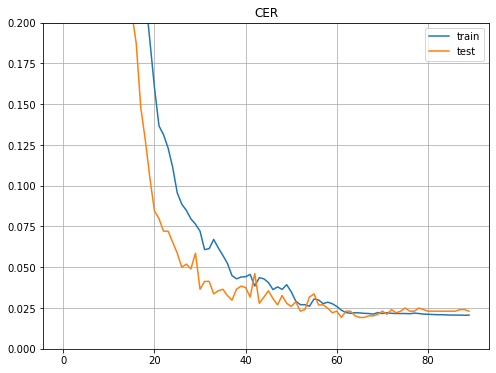

In [75]:
plot_graphs(cer_train_arr_rt_shft_img, cer_test_arr_rt_shft_img)

In [73]:
print(f"CER on test (with all data augmentatin: rotation + shift) = {np.min(cer_test_arr_rt_shft_img) * 100:.3}%")

CER on test (with all data augmentatin: rotation + shift) = 1.92%


Здесь также наблюдается похожая картина - можно было остановить обучение примерно на 65-70 эпохах.

Еще большее количество трейновой выборки не помогло нам улучшить результат - предыдущая модель показала результат немного лучшую точность (1.25% против 1.92%), чем данная.

В итоге имеем следующий результат:

In [77]:
print(f"CER on test = {np.min(cer_test_arr[:len(cer_test_arr) - 10]) * 100:.3}%")
print(f"CER on test (with data augmentatin: only rotation) = {np.min(cer_test_arr_rt_img) * 100:.3}%")
print(f"CER on test (with all data augmentatin: rotation + shift) = {np.min(cer_test_arr_rt_shft_img) * 100:.3}%")

CER on test = 2.93%
CER on test (with data augmentatin: only rotation) = 1.25%
CER on test (with all data augmentatin: rotation + shift) = 1.92%
